Rebecca Roskill

rcr2144

MECS 4510

Prof. Hod Lipson

Submitted Sunday, September 19th, 2021

Grace hours used: 0

Grace hours remaining: 96

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
def load_dataset(path):
  # Load dataset from .txt file
  with open(path, 'r') as f:
    lines = f.readlines()
  return [[float(x) for x in line[:-1].split(',')] for line in lines]

In [38]:
from matplotlib import pyplot as plt

def plot_points(points):
  fig = plt.figure(figsize=(10,10))
  x = [p[0] for p in points]
  y = [p[1] for p in points]
  plt.scatter(x, y)

In [39]:
import random
import numpy as np

def measure_path(path):
  distance = 0
  for i in range(len(path) - 1):
    p1 = path[i]
    p2 = path[i+1]
    distance += np.sqrt(np.square(p2[1]-p1[1]) + np.square(p2[0]-p1[0]))
  return distance

def random_search(points):
  path = []
  points = [p for p in points]
  p1 = random.choice(points)
  points.remove(p1)
  path += [p1]
  while points:
    p2 = random.choice(points)
    points.remove(p2)
    p1 = p2
    path += [p1]
  distance = measure_path(path)
  return (distance, path)

def plot_path(path):
  fig = plt.figure(figsize=(5,5))
  x = [p[0] for p in path]
  y = [p[1] for p in path]
  plt.scatter(x, y, zorder=2)
  for i in range(1, len(path)):
    x1, y1 = path[i - 1]
    x2, y2 = path[i]
    plt.plot([x1, x2], [y1, y2], c='orange', zorder=1)

In [40]:
n_trials = 100

def run_random_search(points, n_trials):
  best_dist = [float('inf')]
  best_path = None

  for i in range(n_trials):
    if i % (n_trials/10) == 0:
      print(i, ' & ', round(best_dist[-1], 2), ' \\\\')
    distance, path = random_search(points)
    if distance < best_dist[-1]:
      best_dist += [distance]
      best_path = path
    else:
      best_dist += [best_dist[-1]]

  fig = plt.figure(figsize=(10,5))
  plt.subplot(121)
  plot_path(best_path, fig)
  plt.title('Best path')
  plt.subplot(122)
  plt.plot(range(n_trials + 1), best_dist)
  plt.title('Best path length vs. trial')
  plt.xlabel('Trial')
  plt.ylabel('Best path length')

  return best_dist, best_path

Batch 0 of 10
Best score inf


KeyboardInterrupt: ignored

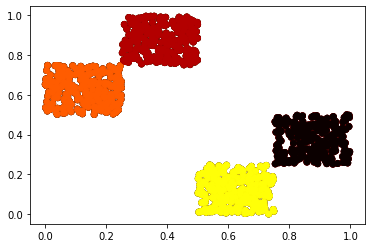

In [41]:
#!pip install pathos #Multi processing

from pathos.multiprocessing import ProcessPool
from pathos import multiprocessing

from sklearn.cluster import KMeans
import matplotlib.cm as cm
random_state = 170

def group_regions(points):
  n_choices = range(1, 10)
  prev_err = float('inf')
  prev_region_nos = None
  prev_n = None

  # Try clustering with a few different n_clusters
  for n in n_choices:
    X = [list(p) for p in points]
    k_means = KMeans(n_clusters=n, random_state=random_state)
    region_nos = k_means.fit_predict(X)

    # Get error, compare to previous n to see if it improves by > 10%
    err = sum([min(e) for e in k_means.transform(X)])
    if err / prev_err > 0.9:
      return prev_n, prev_region_nos
    plt.scatter([x[0] for x in X], [x[1] for x in X], c=[cm.hot(r/n) for r in region_nos])
    prev_n = n
    prev_err = err
    prev_region_nos = region_nos
  return n, region_nos

def mutate(parents, bb_bounds, p_mutate=0.5):
  offspring = []
  for parent in parents:
    offspring += [[p if random.uniform(0, 1) > p_mutate else random.uniform(0, 1) for p in parent]]
  return offspring

def recombine(parents, bb_bounds):
  offspring = []
  if len(parents) > 2:
    for i in range(len(parents) - 1):
      new = []
      for bb_start, bb_end in bb_bounds:
        new += random.choice([parents[i][bb_start:bb_end], parents[i+1][bb_start:bb_end]])
      offspring += [new]
  else:
    offspring = parents
  return offspring

def reproduce(parents, bb_bounds, n_processes, mutation=0.5, recombination=0.5):
  input_mutate = parents[:int(0.5 * mutation * len(parents))]
  n_dedicated = len(input_mutate)
  input_recombine = parents[n_dedicated:n_dedicated + int(0.5 * recombination * len(parents))]
  n_dedicated += len(input_recombine)
  input_both = parents[n_dedicated:n_dedicated + int(mutation * recombination * len(parents))] 
  n_dedicated += len(input_both)
  input_neither = parents[n_dedicated:]
  
  offspring = []
  while len(offspring) < n_processes:
    offspring += mutate(input_mutate, bb_bounds)
    offspring += recombine(input_recombine, bb_bounds)
    offspring += recombine(mutate(input_both, bb_bounds), bb_bounds)
    offspring += input_neither
  offspring = offspring[:n_processes]

  return offspring

def assess_input(input, points):
  # Create ordering based on the priority weights
  path = [p for _, p in sorted(zip(input, points))]
  # Assess fitness based on path length of the ordering
  score = measure_path(path)
  return (score, path)

def run_simple_evolutionary_search(points, n_trials, n_processes):
  # Place cities on the gene (list) in accordance with region
  points_ordered = []
  n_regions, region_nos = group_regions(points)
  region_bounds = []
  last_region_end = 0
  for i in range(n_regions):
    points_in_region = [p for j, p in enumerate(points) if region_nos[j] == i]
    points_ordered += points_in_region
    region_bounds += [[last_region_end, last_region_end + len(points_in_region)]]
    last_region_end += len(points_in_region)

  # Randomize priority weights for each city
  top_p = 0.05
  top_k = int(top_p * n_processes)
  pool = ProcessPool(nodes=2)
  inputs = [[random.uniform(0,1) for p in points_ordered] for i in range(n_processes)]
  
  # Look for best path while running evolutionary process
  best_dist = float('inf')
  best_path = None
  n_batches = int(n_trials/n_processes)
  for n in range(n_batches):
    print('Batch', n, 'of', n_batches)
    print('Best score', best_dist)
    score_path_pairs = [x for x in pool.imap(assess_input, inputs, [points_ordered for i in inputs])]
    paths = [path for _, path in score_path_pairs]
    scores = [score for score, _ in score_path_pairs]

    # Create new inputs: perform operators (crossovers/mutations/segment inversion)
    top_inputs =  [i for _, i in sorted(zip(scores, inputs))][:top_k]
    top_paths = [(s, p) for s, p in sorted(score_path_pairs)]
    if top_paths[0][0] < best_dist:
      best_dist = top_paths[0][0]
      best_path = top_paths[0][1]
    inputs = reproduce(top_inputs, region_bounds, n_processes)

  top_paths = sorted([x for x in pool.imap(assess_input, inputs, [points_ordered for i in inputs])])
  if top_paths[0][0] < best_dist:
    best_dist = top_paths[0][0]
    best_path = top_paths[0][1]

  return best_dist, best_path

if __name__ == '__main__':
  points = load_dataset('/content/drive/My Drive/Senior Year/Evolutionary Algos/tsp.txt')
  distance, path = run_simple_evolutionary_search(points, 100, 10)
  plot_path(path, fig)
  distance